In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_california_housing
from statsmodels.stats.weightstats import ztest
from scipy.stats import ks_2samp
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from catboost import CatBoostClassifier, Pool, cv, EShapCalcType, EFeaturesSelectionAlgorithm
pd.pandas.set_option("display.max_columns",None)
%matplotlib inline

In [93]:
# Util functions
def create_fig():
    
    fig,ax = plt.subplots(figsize=(10,6))
    ax.grid(which='major', axis='y', color='#758D99', alpha=0.6, zorder=1)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    
    return fig, ax

def multi_mahalanobis(target_point:np.ndarray, reference_points:np.ndarray):
    
    if type(target_point) == float or type(target_point) == int:
        
        return (reference_points - target_point)**2 / (np.cov(reference_points))

    diff = reference_points - target_point
    
    cov = np.cov(reference_points.T)
            
    inv_covmat = np.linalg.inv(cov)
    
    left = np.dot(diff, inv_covmat)
    mahal = np.dot(left, diff.T)
    

    return mahal.diagonal()

### Using correlation for feature selection: learning the function $y = x_1x_2 + x_3^2 + x1$
- Low correlation does not imply low predictive power

In [185]:
# Create a fake dataset
n = 50000

x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
x3 = np.random.normal(size=n)

y = x1*x2 + x3**2 + x1

data = pd.DataFrame({'x1':x1, 'x2':x2, 'x3':x3, 'y':y})
data.head()

,x1,x2,x3,y
0,-0.243022,1.039130,0.354150,-0.370132
1,-2.045612,-0.735520,0.516234,-0.274526
2,0.054396,1.684904,0.552751,0.451582
3,-0.459771,-0.236450,-0.131698,-0.333713
4,-0.234194,0.435908,-1.191516,1.083429


In [186]:
# Look at correlation matrix
data.corr()

,x1,x2,x3,y
x1,1.000000,-0.001333,-0.005507,0.501971
x2,-0.001333,1.000000,-0.000503,-0.001778
x3,-0.005507,-0.000503,1.000000,0.019095
y,0.501971,-0.001778,0.019095,1.000000


In [187]:
# Create training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data[['x1']], data['y'], test_size=0.20)
print(x_train.shape)
x_train.head()

(40000, 1)


,x1
16929,-0.889484
17150,0.414268
30587,-0.392389
38434,0.133040
41469,1.267242


In [188]:
# Fit random forest using only x1 as a feature
model = RandomForestRegressor(n_estimators=500, max_depth=6)
model.fit(x_train.values.reshape(-1,1), y_train)

RandomForestRegressor(max_depth=6, n_estimators=500)

/Users/HarrisonHoffman/Desktop/DataScience/envs/baseprojects/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAPE between actual and predicted: 6.66347298248034
R-Squared between actual and predicted: 0.2536115264640161


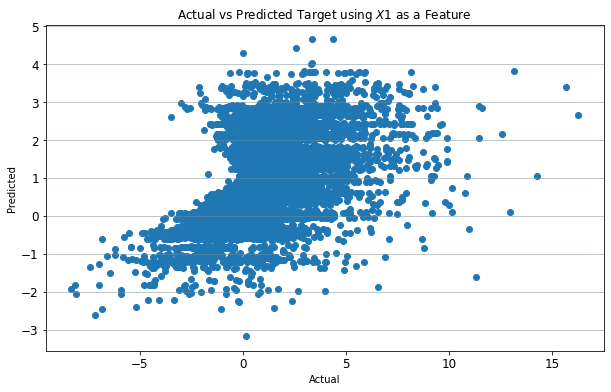

In [189]:
# Evaluate predictions on test set
preds = model.predict(x_test)

fig, ax = create_fig()
ax.scatter(y_test, preds)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted Target using $X1$ as a Feature')

print(f'MAPE between actual and predicted: {mean_absolute_percentage_error(y_test, preds)}')
print(f'R-Squared between actual and predicted: {r2_score(y_test, preds)}')

In [190]:
# Create training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data[['x1','x2','x3']], data['y'], test_size=0.20)
print(x_train.shape)
x_train.head()

(40000, 3)


,x1,x2,x3
31675,-1.955055,0.587020,0.251535
25295,-0.602995,1.527895,0.045753
43814,-0.906124,-1.274655,0.138055
20866,0.666513,-0.751887,-1.491359
20522,0.536762,-0.173588,0.045723


In [191]:
# Fit random forest using all features
model = RandomForestRegressor(n_estimators=500, max_depth=6)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=500)

MAPE between actual and predicted: 1.4802323989570438
R-Squared between actual and predicted: 0.8809329902917163


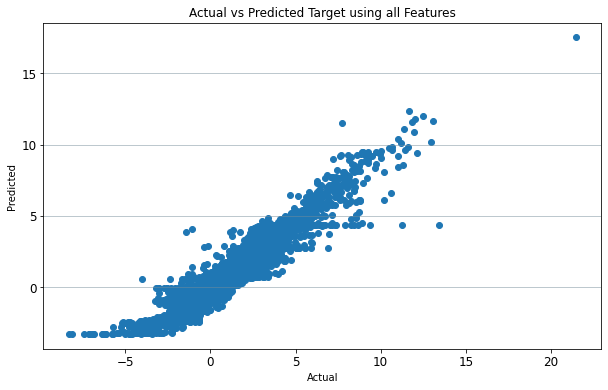

In [193]:
# Evaluate predictions on test set
preds = model.predict(x_test)

fig, ax = create_fig()
ax.scatter(y_test, preds)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted Target using all Features')

print(f'MAPE between actual and predicted: {mean_absolute_percentage_error(y_test, preds)}')
print(f'R-Squared between actual and predicted: {r2_score(y_test, preds)}')

In [201]:
y_train.describe()

count    40000.000000
mean         0.995204
std          2.004660
min        -10.755540
25%         -0.062930
50%          0.663482
75%          1.880195
max         20.720567
Name: y, dtype: float64

In [202]:
y_test.describe()

count    10000.000000
mean         0.990198
std          1.989229
min         -8.320167
25%         -0.041274
50%          0.656811
75%          1.852250
max         21.466919
Name: y, dtype: float64

#### Doing better with a linear model - random forests can't extrapolate

In [203]:
x_train['x1x2'] = x_train['x1']*x_train['x2']
x_train['x3^2'] = x_train['x3']**2

x_test['x1x2'] = x_test['x1']*x_test['x2']
x_test['x3^2'] = x_test['x3']**2

x_train.head()

,x1,x2,x3,x1x2,x3^2
31675,-1.955055,0.587020,0.251535,-1.147656,0.063270
25295,-0.602995,1.527895,0.045753,-0.921313,0.002093
43814,-0.906124,-1.274655,0.138055,1.154996,0.019059
20866,0.666513,-0.751887,-1.491359,-0.501143,2.224151
20522,0.536762,-0.173588,0.045723,-0.093175,0.002091


In [204]:
# Fit linear model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

MAPE between actual and predicted: 3.870643889242756e-15
R-Squared between actual and predicted: 1.0


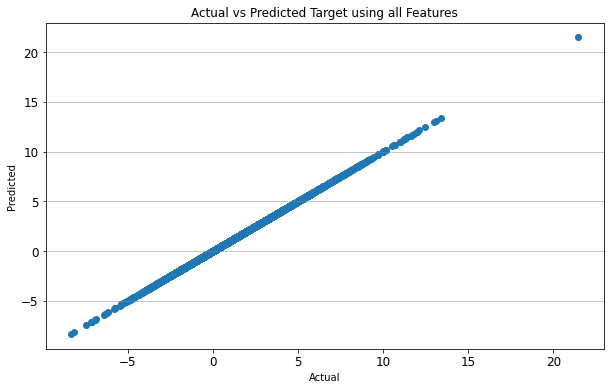

In [205]:
# Evaluate predictions on test set
preds = model.predict(x_test)

fig, ax = create_fig()
ax.scatter(y_test, preds)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted Target using all Features')

print(f'MAPE between actual and predicted: {mean_absolute_percentage_error(y_test, preds)}')
print(f'R-Squared between actual and predicted: {r2_score(y_test, preds)}')

In [206]:
model.coef_

array([ 1.00000000e+00,  2.22044605e-16, -4.44089210e-16,  1.00000000e+00,
        1.00000000e+00])

### Statistical significance does not imply a meaningful difference
- Effect size should be considered

/Users/HarrisonHoffman/Desktop/DataScience/envs/baseprojects/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/HarrisonHoffman/Desktop/DataScience/envs/baseprojects/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


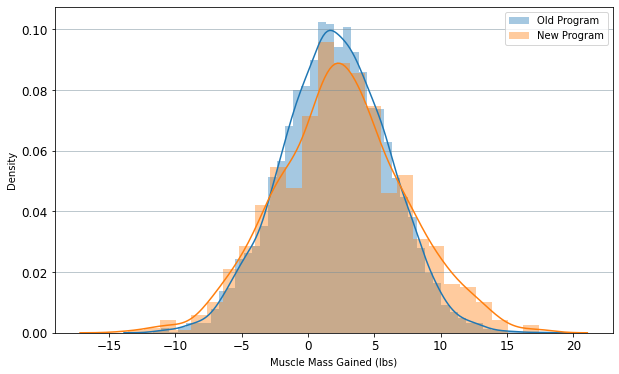

In [273]:
n1 = 5000
n2 = 1000

old_program = np.random.normal(loc=2, scale=4, size=n1)
new_program = np.random.normal(loc=2.4, scale=4.8, size=n2)

fig, ax = create_fig()
sns.distplot(old_program, label='Old Program')
sns.distplot(new_program, label='New Program')
ax.set_xlabel('Muscle Mass Gained (lbs)')
ax.legend()

In [274]:
pd.Series(old_program).describe()

count    5000.000000
mean        2.033940
std         3.989209
min       -11.700204
25%        -0.641931
50%         2.029038
75%         4.756619
max        17.510815
dtype: float64

In [275]:
pd.Series(new_program).describe()

count    1000.000000
mean        2.471393
std         4.815048
min       -13.565039
25%        -0.548481
50%         2.352121
75%         5.420964
max        17.425636
dtype: float64

# $d={\frac {{\bar {x}}_{1}-{\bar {x}}_{2}}{s}}$


# $s={\sqrt {\frac {(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}}}$

### ${\bar {x}}_{1}$ -  group 1 sample mean

In [279]:
ztest(old_program, new_program)

(-3.0516057103606307, 0.0022762088288216372)

In [282]:
# Compute effect size
sd_pooled = np.sqrt(((n1-1)*old_program.std()**2 + (n2-1)*new_program.std()**2) / (n1 + n2 - 2))
cohen_d = (new_program.mean() - old_program.mean()) / sd_pooled

cohen_d

0.10573083435878816

In [278]:
ks_2samp(old_program, new_program)

KstestResult(statistic=0.0714, pvalue=0.0003932360604497198)

### Tree-based feature importance can be very deceiving 

In [45]:
# Read in academic success data
data = pd.read_csv('Dropout_Academic Success - Sheet1.csv')

# Only include students that have graduated or dropped out
data = data[data['Target'] != 'Enrolled']

# Convert target to a binary value
data['Target'].replace({'Graduate':1, 'Dropout':0}, inplace=True)


print(data.shape)
data.head()

(3630, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,1
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,1
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,1


In [46]:
data['Target'].mean()

0.6085399449035813

In [47]:
# Look at missing values
na_props:pd.DataFrame = data.isna().mean().reset_index()
na_props.columns = ['feature','missing_prop']

na_mapping = dict(zip(na_props.feature, na_props.missing_prop))

na_props.sort_values('missing_prop', ascending=False).head(10)

,feature,missing_prop
0,Marital status,0.0
19,Age at enrollment,0.0
21,Curricular units 1st sem (credited),0.0
22,Curricular units 1st sem (enrolled),0.0
23,Curricular units 1st sem (evaluations),0.0
24,Curricular units 1st sem (approved),0.0
25,Curricular units 1st sem (grade),0.0
26,Curricular units 1st sem (without evaluations),0.0
27,Curricular units 2nd sem (credited),0.0
28,Curricular units 2nd sem (enrolled),0.0


In [40]:
cat_cols = ['Marital Status','Application mode','Course','Daytime/evening attendance', 'Previous qualification',
           'Nacionality',"Mother's qualification", "Father's qualification","Mother's occupation",
            "Father's occupation",'Displaced', 'Educational special needs', 'Debtor','Tuition fees up to date',
           'International']



In [48]:
# Create train/test split
x,y = data.drop('Target', axis=1), data['Target']

# Add random variable to inputs to evaluate feature importance
x['rv'] = np.random.normal(size=len(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print(x_train.shape)
print(x_test.shape)

(2904, 37)
(726, 37)


In [51]:
# Specify index of categorical features in input data
cat_features = [x.columns.get_loc(col) for col in cat_cols if col in x.columns]

# Model parameter dict
params = {'iterations':1000,
          'loss_function':'Logloss',
          'depth':6,
          'custom_loss':['AUC', 'Recall']}

# Instantiate model
model = CatBoostClassifier(**params)

# Fit model
model.fit(
    x_train.replace(np.nan,'none'),
    y_train,
    cat_features=cat_features,
    eval_set=(x_test.replace(np.nan,'none'), y_test),
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041235
0:	learn: 0.6556774	test: 0.6561569	best: 0.6561569 (0)	total: 6ms	remaining: 6s
50:	learn: 0.2513740	test: 0.2585637	best: 0.2585637 (50)	total: 226ms	remaining: 4.2s
100:	learn: 0.2166107	test: 0.2357065	best: 0.2357065 (100)	total: 448ms	remaining: 3.99s
150:	learn: 0.1974485	test: 0.2270652	best: 0.2270652 (150)	total: 737ms	remaining: 4.14s
200:	learn: 0.1799145	test: 0.2238258	best: 0.2237738 (193)	total: 989ms	remaining: 3.93s
250:	learn: 0.1653744	test: 0.2213831	best: 0.2213831 (250)	total: 1.27s	remaining: 3.78s
300:	learn: 0.1550429	test: 0.2192798	best: 0.2192798 (300)	total: 1.52s	remaining: 3.54s
350:	learn: 0.1442759	test: 0.2180592	best: 0.2179435 (329)	total: 1.77s	remaining: 3.28s
400:	learn: 0.1334529	test: 0.2172477	best: 0.2170846 (398)	total: 2.06s	remaining: 3.08s
450:	learn: 0.1243455	test: 0.2168805	best: 0.2168076 (404)	total: 2.31s	remaining: 2.81s
500:	learn: 0.1146355	test: 0.2160252	best: 0.2156610 (489)	total: 2.55s	remaining

In [57]:
pred_probs_train = model.predict_proba(x_train)[:,1]
pred_probs = model.predict_proba(x_test)[:,1]

In [54]:
# Evaluate predictions on the test set
preds = model.predict(x_test)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print(roc_auc_score(y_test, pred_probs))
print(ks_2samp(pred_probs[y_test==1], pred_probs[y_test!=1]).statistic)

[[224  44]
 [ 23 435]]
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       268
           1       0.91      0.95      0.93       458

    accuracy                           0.91       726
   macro avg       0.91      0.89      0.90       726
weighted avg       0.91      0.91      0.91       726

0.961643746333833
0.8065241478198527


/Users/HarrisonHoffman/Desktop/DataScience/envs/baseprojects/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/HarrisonHoffman/Desktop/DataScience/envs/baseprojects/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


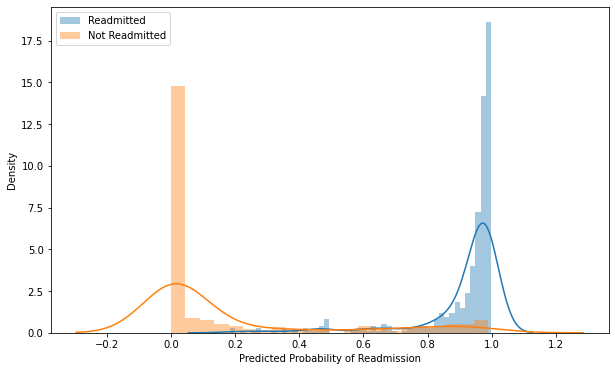

In [58]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(pred_probs[y_test==1], label='Readmitted')
sns.distplot(pred_probs[y_test==0], label='Not Readmitted')
ax.set_xlabel("Predicted Probability of Readmission")
ax.legend()

In [78]:
# Create catboost pool object
test_pool = Pool(x_test, y_test, cat_features=cat_features)

In [76]:
# Evaluate feature importance
feature_importances = model.get_feature_importance(data=test_pool, type='LossFunctionChange')

feat_imp_df = pd.DataFrame({'Feature':model.feature_names_, 'Importance':feature_importances})
feat_imp_df.sort_values("Importance", ascending=False, inplace=True)
feat_imp_df

,Feature,Importance
30,Curricular units 2nd sem (approved),0.069613
16,Tuition fees up to date,0.021129
22,Curricular units 1st sem (enrolled),0.013016
24,Curricular units 1st sem (approved),0.012623
28,Curricular units 2nd sem (enrolled),0.007911
18,Scholarship holder,0.007182
35,GDP,0.005512
3,Course,0.005323
15,Debtor,0.005065
19,Age at enrollment,0.003974


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

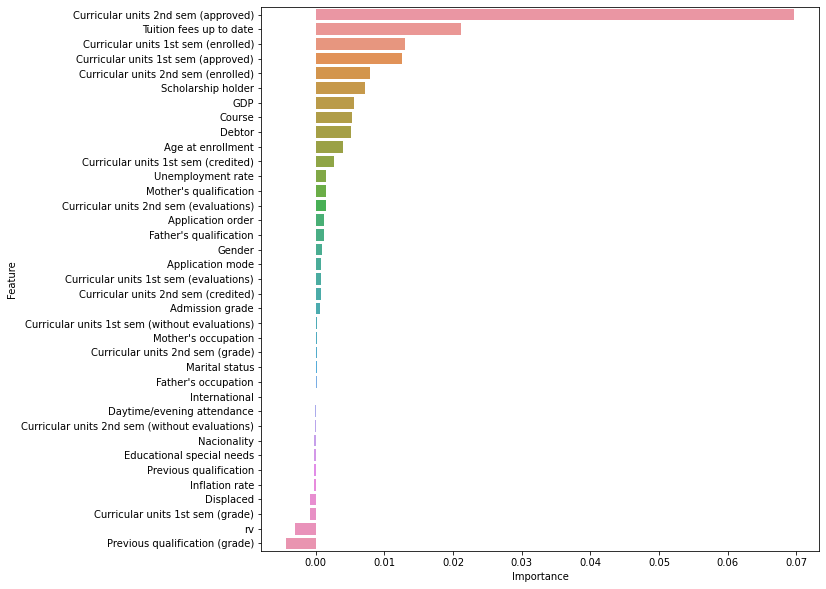

In [77]:
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(x=feat_imp_df['Importance'], y=feat_imp_df['Feature'])